In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as vb_sparse
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import autograd.numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

analysis_name = 'simulated_data_for_refit'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
# Generate data

true_beta = np.array(range(5))
true_beta = true_beta - np.mean(true_beta)
true_mu = 0.
true_tau = 40.0

true_params = logit_glmm.TrueParameters(
    num_obs_per_group = 2,
    num_groups = 200,
    true_beta = true_beta,
    true_mu = 0.,
    true_tau = 40.0)

x_mat, y_g_vec, y_vec  = true_params.generate_data()
prior_par = logit_glmm.get_default_prior_params(true_params.beta_dim)
glmm_par = logit_glmm.get_glmm_parameters(K=true_params.beta_dim, NG=true_params.num_groups)
logit_glmm.initialize_glmm_pars(glmm_par)
init_par_vec = glmm_par.get_free()

timer = logit_glmm.Timer()

In [3]:
# Get an initial fit and preconditioner.

model = logit_glmm.LogisticGLMM(
    glmm_par=glmm_par, prior_par=prior_par, x_mat=x_mat,
    y_vec=y_vec, y_g_vec=y_g_vec, num_gh_points=5)

vb_time = time.time()
vb_opt = model.tr_optimize(init_par_vec, gtol=1e-6, maxiter=500)
opt_x = vb_opt.x

timer.tic()
kl_hess = model.get_sparse_free_hessian(opt_x, print_every_n=20)
weight_jac = model.get_sparse_weight_free_jacobian(opt_x, print_every_n=50)
moment_jac = model.moment_wrapper.get_moment_jacobian(opt_x)
timer.toc('Derivatives')


Iter  0  value:  283.167548722
Iter  5  value:  85.830937643
Iter  10  value:  80.2725007358
Optimization terminated successfully.
         Current function value: 80.271301
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
         Hessian evaluations: 0
Group 0 of 199.
Group 20 of 199.
Group 40 of 199.
Group 60 of 199.
Group 80 of 199.
Group 100 of 199.
Group 120 of 199.
Group 140 of 199.
Group 160 of 199.
Group 180 of 199.


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Group 0 of 199
Group 50 of 199
Group 100 of 199
Group 150 of 199


In [4]:
class DiagonalModel(object):
    def __init__(self, model):
        self.model = model
        self.glmm_par = model.glmm_par
        self.free_par = model.glmm_par.get_free()
        self.get_single_par_hessian = autograd.hessian(self.get_single_par_kl)

    def get_single_par_kl(self, single_free_par, ind):
        free_par = np.concatenate(
            [ self.free_par[:ind],
              np.atleast_1d(single_free_par),
              self.free_par[(ind + 1):]])
        self.glmm_par.set_free(free_par)
        return model.get_kl()
    
    def get_hessian_diag(self, free_par, print_every=100):
        self.glmm_par.set_free(free_par)
        self.free_par = model.glmm_par.get_free()
        hess_diag = []
        free_size = self.glmm_par.free_size()
        for ind in range(free_size):
            if ind % print_every == 0:
                print('Ind {} of {}'.format(ind, free_size - 1))
            hess_diag.append(self.get_single_par_hessian(self.free_par[ind], ind))
        return hess_diag
    
diagonal_model = DiagonalModel(model)
diagonal_model.get_single_par_kl(7.0, 3)
diagonal_model.get_single_par_hessian(5.0, 1)
#hess_diag = diagonal_model.get_hessian_diag(opt_x)
#print(np.min(hess_diag))
#preconditioner = sp.sparse.diags([1 / np.sqrt(hess_diag)], [0])

preconditioner = sp.sparse.diags([1 / np.sqrt(kl_hess.diagonal())], [0])


In [5]:
model.objective.preconditioner = preconditioner
cond_init = sp.sparse.linalg.spsolve(preconditioner, opt_x)

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


In [6]:
def simulate_and_fit(refit_model, cond_init, true_params):
    x_mat, y_g_vec, y_vec = \
        true_params.generate_data()
    refit_model.x_mat = x_mat
    refit_model.y_vec = y_vec
    refit_model.y_g_vec = y_g_vec
    #print('x mat: ', x_mat[0, 0], refit_model.x_mat[0, 0])

    vb_time = time.time()
    vb_opt = refit_model.tr_optimize_cond(
        cond_init,
        preconditioner=preconditioner,
        gtol=1e-6, maxiter=500, verbose=False)
    return vb_opt


In [7]:
# model.x_mat, _model.y_g_vec, model.y_vec = \
#     true_params.generate_data()
# model.x_mat[0, 0]

In [8]:
opt_x_sims = []
num_sims = 200
timer.tic()
for sim in range(num_sims):
    if sim % 20 == 0:
        print('Sim {} of {}'.format(sim, num_sims - 1))
    this_vb_opt = simulate_and_fit(model, cond_init, true_params)
    assert(this_vb_opt.success == 1)
    #print(this_vb_opt.message)
    this_opt_x = model.objective.uncondition_x(this_vb_opt.x)
    #print('This opt x:', this_opt_x[0:2])
    
    opt_x_sims.append(copy.deepcopy(this_opt_x))
timer.toc('Simulations')
print('Done.')

Sim 0 of 199
Sim 20 of 199
Sim 40 of 199
Sim 60 of 199
Sim 80 of 199
Sim 100 of 199
Sim 120 of 199
Sim 140 of 199
Sim 160 of 199
Sim 180 of 199
Done.


In [9]:
print(timer.time_dict)

{'Derivatives': 13.162471294403076, 'Simulations': 159.1504466533661}


In [10]:
opt_x_array = np.array(opt_x_sims)
print(np.linalg.norm(opt_x_sims[3] - opt_x_sims[1]))
print(np.linalg.norm(opt_x_sims[3] - opt_x))
print(np.linalg.norm(opt_x_sims[4] - opt_x))

#simulate_and_fit(model, cond_init, true_params)

12.4650801055
11.5981847841
13.3873619427


In [11]:
def get_u_vec(free_par):
    model.moment_wrapper.set_moments(free_par)
    return model.moment_wrapper.moment_par['e_u'].get()

u_vecs = np.array([ get_u_vec(free_par) for free_par in opt_x_sims ])

def get_beta_vec(free_par):
    model.moment_wrapper.set_moments(free_par)
    return model.moment_wrapper.moment_par['e_beta'].get()

beta_vecs = np.array([ get_beta_vec(free_par) for free_par in opt_x_sims ])

(200, 200)


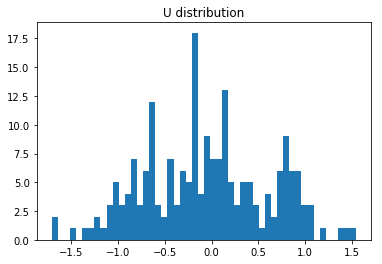

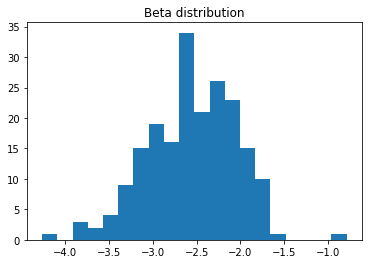

In [12]:
print(u_vecs.shape)
#print(u_vecs[:, 1])
plt.figure()
plt.title('U distribution')
hist_vals = plt.hist(u_vecs[:, 10], 50)
np.sum(hist_vals[0])

plt.figure()
plt.title('Beta distribution')
unused = plt.hist(beta_vecs[:, 0], 20)

In [13]:
# Write the result to a JSON file for use in R.

run_name = 'simulation'

pickle_output_filename = os.path.join(data_dir, '%s_python_refit_jackknife_results.pkl' % analysis_name)
pickle_output = open(pickle_output_filename, 'wb')

# Unlike with JSON, numpy arrays can be pickled.
# Note that it does not seem that you can pickle a sparse Cholesky decomposition.
pickle_result_dict = {  'num_gh_points': model.num_gh_points,
                        'true_params': true_params,
                        'glmm_par_sims': opt_x_sims,
                        'glmm_par_free': opt_x,
                        'weight_jac': vb_sparse.pack_csr_matrix(weight_jac),
                        'kl_hess': vb_sparse.pack_csr_matrix(kl_hess),
                        'moment_jac': moment_jac,
                        'x_mat': x_mat,
                        'y_g_vec': y_g_vec,
                        'y_vec': y_vec
                     }

# Pickle dictionary using protocol 0.
pickle.dump(pickle_result_dict, pickle_output)
pickle_output.close()

print(pickle_output_filename)


print('\n\nDONE.')


/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/simulated_data_for_refit_python_jackknife_results.pkl


DONE.
